In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

# ignore warnings about convergence
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

In [35]:
def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mu_ = np.mean(X, axis=0)
        self.d_ = np.linalg.norm(X - self.mu_, axis=0, ord=2)
        self.d_[self.d_ == 0] = 1  # avoid division by zero
        return self
    
    def transform(self, X):
        X_centered = X - self.mu_
        X_normalized = X_centered / self.d_
        return X_normalized


In [37]:
file_path = "case1Data.csv"
data = pd.read_csv(file_path)

y = data['y']
X = data.drop(columns=['y'])

# drop C_02
X = X.drop(columns=['C_02'])

categorical_cols = [col for col in X.columns if 'C_' in col]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [38]:
# Custom Normalizer
from sklearn.preprocessing import Normalizer
normalizer = CustomNormalizer() #Normalizer(norm='l2')

# Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('custom_norm', normalizer)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor for elastic net and ridge (l2 normalization)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# preprocessor for lasso (standardization)
numerical_transformer_lasso = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_lasso, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [ ]:
# Define cross-validation strategy (5-fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
k = 100; # try k values of lambda
alphas = np.logspace(-4, 4, k)

In [52]:

# Full model pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', RidgeCV(alphas=alphas, cv=5))
])

ridge_cv_scores = cross_val_score(ridge_pipeline,
                                  X,
                                  y,
                                  cv=cv,
                                  scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_cv_scores)
#print("\nRidge model RMSE per fold:", ridge_rmse)
print("Ridge model average RMSE:", ridge_rmse.mean())

# Build Lasso model pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor_lasso),
    ('lasso', LassoCV(alphas=alphas, cv=5, random_state=42))
])
lasso_cv_scores = cross_val_score(lasso_pipeline,
                                  X,
                                  y,
                                  cv=cv,
                                  scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_cv_scores)
#print("\nLasso model RMSE per fold:", lasso_rmse)
print("Lasso model average RMSE:", lasso_rmse.mean())

# Build ElasticNet model pipeline
enet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('enet', ElasticNetCV(alphas=alphas, l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42))
])
enet_cv_scores = cross_val_score(enet_pipeline,
                                 X,
                                 y,
                                 cv=cv,
                                 scoring='neg_mean_squared_error')
enet_rmse = np.sqrt(-enet_cv_scores)
#print("\nElasticNet model RMSE per fold:", enet_rmse)
print("ElasticNet model average RMSE:", enet_rmse.mean())

Ridge model average RMSE: 39.50141939551042
Lasso model average RMSE: 30.990236626556754
ElasticNet model average RMSE: 38.99420500394113


In [41]:
# Ridge
ridge_rmse_path = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_regu_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', ridge)
    ])
    scores = cross_val_score(ridge_regu_pipeline,
                             X,
                             y,
                             cv=5,
                             scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    ridge_rmse_path.append(rmse)

ridge_rmse_path = np.array(ridge_rmse_path)

# Lasso
lasso_regu_pipeline = Pipeline([
    ('preprocessor', preprocessor_lasso),
    ('lasso', LassoCV(alphas=alphas, cv=5, random_state=42))
])
lasso_regu_pipeline.fit(X, y)
lasso_rmse_path = np.sqrt(lasso_regu_pipeline.named_steps['lasso'].mse_path_.mean(axis=1))

# ElasticNet (3 l1_ratios)
enet_rmse_paths = {}
for l1_ratio in [0.1, 0.5, 0.9]:
    enet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5, random_state=42)
    enet_regu_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('enet', enet)
    ])
    enet_regu_pipeline.fit(X,y)
    rmse_path = np.sqrt(enet_regu_pipeline.named_steps['enet'].mse_path_.mean(axis=1))
    enet_rmse_paths[l1_ratio] = rmse_path

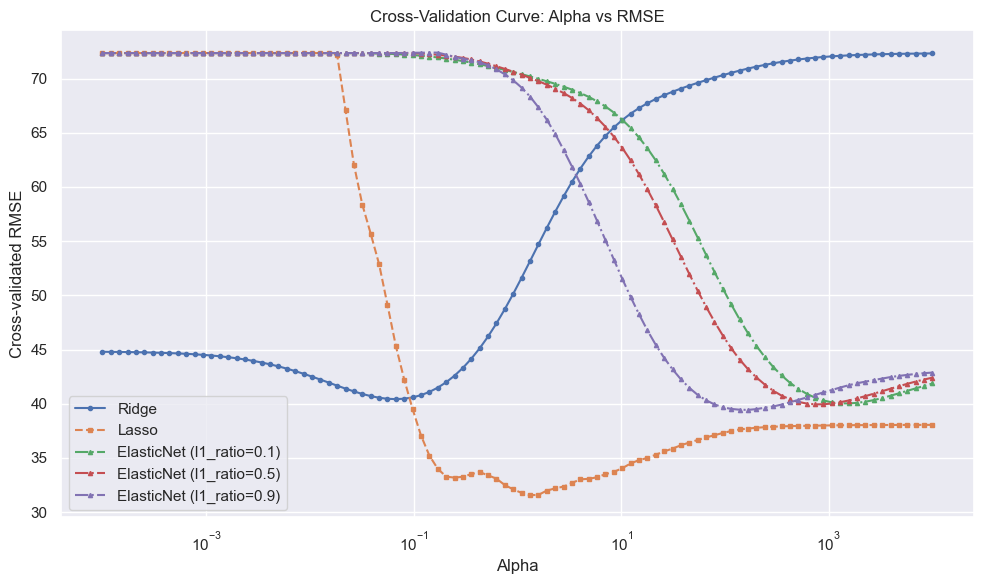

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_rmse_path, label='Ridge', linestyle='-', marker='o', markersize=3)
plt.plot(alphas, lasso_rmse_path, label='Lasso', linestyle='--', marker='s', markersize=3)
for l1_ratio, rmse_path in enet_rmse_paths.items():
    plt.plot(alphas, rmse_path, label=f'ElasticNet (l1_ratio={l1_ratio})', linestyle='-.', marker='^', markersize=3)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cross-validated RMSE')
plt.title('Cross-Validation Curve: Alpha vs RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Ridge Validation
ridge_pipeline.fit(X, y)
best_ridge_alpha = ridge_pipeline.named_steps['ridge'].alpha_
print(f"Best Ridge alpha: {best_ridge_alpha}")

final_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=best_ridge_alpha))
])
ridge_cv_scores = cross_val_score(final_ridge, X, y, cv=cv, scoring='neg_mean_squared_error')
ridge_rmse = np.sqrt(-ridge_cv_scores)
#print("\n[Ridge] RMSE per fold:", ridge_rmse)
print("[Ridge] Average RMSE:", ridge_rmse.mean())

# Lasso Validation
lasso_pipeline.fit(X, y)
best_lasso_alpha = lasso_pipeline.named_steps['lasso'].alpha_
print(f"Best Lasso alpha: {best_lasso_alpha}")

final_lasso = Pipeline([
    ('preprocessor', preprocessor_lasso),
    ('lasso', Lasso(alpha=best_lasso_alpha))
])
lasso_cv_scores = cross_val_score(final_lasso, X, y, cv=cv, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_cv_scores)
#print("\n[Lasso] RMSE per fold:", lasso_rmse)
print("[Lasso] Average RMSE:", lasso_rmse.mean())

# ElasticNet Validation
enet_pipeline.fit(X, y)
best_enet_alpha = enet_pipeline.named_steps['enet'].alpha_
best_enet_l1_ratio = enet_pipeline.named_steps['enet'].l1_ratio_
print(f"Best ElasticNet alpha: {best_enet_alpha}")
print(f"Best ElasticNet l1_ratio: {best_enet_l1_ratio}")

final_enet = Pipeline([
    ('preprocessor', preprocessor),
    ('enet', ElasticNet(alpha=best_enet_alpha, l1_ratio=best_enet_l1_ratio))
])
enet_cv_scores = cross_val_score(final_enet, X, y, cv=cv, scoring='neg_mean_squared_error')
enet_rmse = np.sqrt(-enet_cv_scores)
#print("\n[ElasticNet] RMSE per fold:", enet_rmse)
print("[ElasticNet] Average RMSE:", enet_rmse.mean())

Best Ridge alpha: 0.055908101825122285
[Ridge] Average RMSE: 35.13163479343161
Best Lasso alpha: 0.7564633275546291
[Lasso] Average RMSE: 30.665437624855805
Best ElasticNet alpha: 0.005994842503189409
Best ElasticNet l1_ratio: 0.9
[ElasticNet] Average RMSE: 34.71404847898374


In [43]:
file_path = "case1Data_Xnew.csv"
data_new = pd.read_csv(file_path)
X_new = data_new.drop(columns=['C_02'])

In [44]:
# use the fitted lasso to predict X_new
lasso_predictions = lasso_pipeline.predict(X_new)
# save predictions to a CSV
lasso_predictions_df = pd.DataFrame(lasso_predictions, columns=['y'])
lasso_predictions_df.to_csv("lasso_predictions.csv", index=False, header=False)